# 04 - RAG Pipeline for Explainable Fraud Detection

End-to-end inference pipeline combining:
1. GNN model predictions
2. FAISS-based case retrieval
3. In-Context Learning (ICL) prompt generation
4. LLM integration for explainable analysis

**Objectives:**
- Load trained model and case memory
- Build and test inference pipeline
- Generate ICL prompts from retrieved cases
- Demonstrate full analysis workflow

## 1. Setup & Imports

In [1]:
import sys
sys.path.append('..')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Check device
device = 'cpu'  # Using CPU for compatibility
print(f"Device: {device}")
print("Imports complete!")

Device: cpu
Imports complete!


## 2. Load All Components

In [2]:
# Load the graph data
from src.data.graph_builder import GraphBuilder

builder = GraphBuilder('../data/elliptic_bitcoin_dataset')
data = builder.build()

print(f"Graph loaded:")
print(f"  Nodes: {data.num_nodes:,}")
print(f"  Edges: {data.num_edges:,}")
print(f"  Features: {data.num_node_features}")

Loading Elliptic dataset...
  Features: 203,769 nodes, 167 columns
  Labels: 203,769 entries
  Edges: 234,355 directed edges
  Node mapping: 203,769 unique nodes
  Normalizing features...
  Features shape: (203769, 166)
  Time steps: 1 to 49 (49 unique)
  Label distribution:
    unknown: 157,205 (77.15%)
    licit: 42,019 (20.62%)
    illicit: 4,545 (2.23%)
  Edge index shape: (2, 234355)

Temporal splits:
  Train: 34 time steps, 136,265 nodes (29,894 labeled)
  Val:   7 time steps, 30,680 nodes (7,829 labeled)
  Test:  8 time steps, 36,824 nodes (8,841 labeled)

Class weights: licit=0.5541, illicit=5.1226

PyG Data Object Created
Nodes: 203,769
Edges: 234,355
Features: 166
Train nodes: 29,894
Val nodes: 7,829
Test nodes: 8,841
Graph loaded:
  Nodes: 203,769
  Edges: 234,355
  Features: 166


In [5]:
# Load trained GraphSAGE model
from src.models.graphsage import GraphSAGEModel

model = GraphSAGEModel(
    num_features=data.num_node_features,
    num_classes=2,
    hidden_dims=[256, 128],
    embedding_dim=64,
    dropout=0.3
)

# Load checkpoint
checkpoint = torch.load('../baseline/checkpoints/graphsage_baseline.pt', map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Model loaded!")
print(f"  Test F1: {checkpoint['metrics']['test_f1']:.4f}")
print(f"  Test AUC: {checkpoint['metrics']['test_auc']:.4f}")

Model loaded!
  Test F1: 0.1482
  Test AUC: 0.7717


In [6]:
# Load case memory and FAISS index
from src.memory.case_store import CaseMemory
from src.retrieval.faiss_index import FAISSIndex

case_memory = CaseMemory.load('../case_memory')
faiss_index = FAISSIndex(embedding_dim=64)
faiss_index.load('../case_memory/faiss.index')

print(f"Case memory: {len(case_memory.cases)} cases")
print(f"FAISS index: {faiss_index.num_vectors} vectors")

Loaded 1000 cases from ../case_memory
Loaded FAISS index from ../case_memory/faiss.index: 1000 vectors
Case memory: 1000 cases
FAISS index: 1000 vectors


## 3. Initialize Inference Pipeline

In [8]:
from src.pipeline.inference import InferencePipeline

pipeline = InferencePipeline(
    model=model,
    data=data,
    case_memory=case_memory,
    faiss_index=faiss_index,
    device=device
)

print("Inference pipeline initialized!")

Inference pipeline initialized!


## 4. Single Transaction Analysis

Let's analyze a suspicious transaction step by step.

In [9]:
# Find a high-risk transaction
with torch.no_grad():
    logits, embeddings = model(data.x, data.edge_index)
    fraud_scores = torch.softmax(logits, dim=1)[:, 1].numpy()

# Get high-risk but unlabeled transactions
labels = data.y.numpy()
unlabeled_mask = labels == -1
high_risk_unlabeled = np.where(unlabeled_mask & (fraud_scores > 0.7))[0]

print(f"Found {len(high_risk_unlabeled)} high-risk unlabeled transactions")
print(f"\nSample high-risk transactions (fraud score > 0.7):")
for idx in high_risk_unlabeled[:5]:
    print(f"  Node {idx}: fraud_score = {fraud_scores[idx]:.4f}")

Found 53166 high-risk unlabeled transactions

Sample high-risk transactions (fraud score > 0.7):
  Node 19: fraud_score = 0.8185
  Node 56: fraud_score = 0.7542
  Node 75: fraud_score = 0.7221
  Node 84: fraud_score = 0.9393
  Node 87: fraud_score = 0.7805


In [10]:
# Analyze a suspicious transaction (without GNNExplainer for speed)
test_node = high_risk_unlabeled[0] if len(high_risk_unlabeled) > 0 else 12345

result = pipeline.analyze(
    node_idx=test_node,
    k_cases=5,
    generate_explanation=False,  # Skip for speed
    generate_prompt=True
)

print("Analysis Result:")
print(f"  Node: {result['prediction']['node_idx']}")
print(f"  Fraud Score: {result['prediction']['fraud_score']:.4f}")
print(f"  Predicted: {result['prediction']['predicted_label']}")
print(f"  True Label: {result['prediction']['true_label']}")
print(f"\nSimilar Cases Retrieved: {len(result['similar_cases'])}")

Analysis Result:
  Node: 19
  Fraud Score: 0.8185
  Predicted: illicit
  True Label: unknown

Similar Cases Retrieved: 5


In [11]:
# View retrieved similar cases
print("Similar Historical Cases:")
print("=" * 60)
for i, case_data in enumerate(result['similar_cases'], 1):
    case = case_data['case']
    print(f"\n{i}. Case {case.case_id}")
    print(f"   Similarity: {case_data['similarity']:.4f}")
    print(f"   Fraud Score: {case.fraud_score:.4f}")
    print(f"   True Label: {case.true_label}")
    print(f"   Prediction: {case.predicted_label}")

Similar Historical Cases:

1. Case 87
   Similarity: 0.4764
   Fraud Score: 0.9013
   True Label: illicit
   Prediction: illicit

2. Case 106
   Similarity: 0.3799
   Fraud Score: 0.9474
   True Label: illicit
   Prediction: illicit

3. Case 67
   Similarity: 0.3778
   Fraud Score: 0.9014
   True Label: illicit
   Prediction: illicit

4. Case 141
   Similarity: 0.3719
   Fraud Score: 0.9016
   True Label: illicit
   Prediction: illicit

5. Case 116
   Similarity: 0.3650
   Fraud Score: 0.9380
   True Label: illicit
   Prediction: illicit


## 5. ICL Prompt Generation

Generate the In-Context Learning prompt for LLM analysis.

In [12]:
# Display the generated prompt
print("Generated ICL Prompt:")
print("=" * 80)
if 'prompt' in result:
    print(result['prompt'][:3000])  # First 3000 chars
    if len(result['prompt']) > 3000:
        print(f"\n... [truncated, total length: {len(result['prompt'])} chars]")
else:
    print("Prompt not generated")

Generated ICL Prompt:
# AML Transaction Analyst

You are an expert Anti-Money Laundering (AML) analyst specializing in cryptocurrency 
transaction analysis. Your role is to:

1. **Analyze** suspicious Bitcoin transactions flagged by our ML system
2. **Compare** with historical cases to identify patterns
3. **Assess** the likelihood of illicit activity
4. **Recommend** appropriate actions

## Your Expertise:
- Deep knowledge of money laundering typologies (layering, structuring, mixing)
- Understanding of Bitcoin transaction patterns
- Experience with regulatory requirements (BSA/AML, FATF guidelines)
- Pattern recognition across historical fraud cases

## Important Guidelines:
- Base your analysis on the provided data and similar cases
- Provide clear reasoning for your assessment
- Consider both false positive and false negative risks
- Be specific about which patterns inform your decision

## Current Transaction Analysis

**Transaction ID:** #19
**Fraud Score:** 81.9%
**Risk Level:**

In [13]:
# Build prompts with different task types
from src.prompts.icl_constructor import ICLPromptBuilder, TransactionContext

builder = ICLPromptBuilder(max_cases=3)

# Create transaction context
tx_context = TransactionContext(
    node_idx=test_node,
    fraud_score=result['prediction']['fraud_score'],
    predicted_label=result['prediction']['predicted_label'],
    embedding=result['embedding'].tolist(),
    top_features=[],
    feature_summary="Transaction flagged by ML model",
    num_neighbors=10,
    in_degree=5,
    out_degree=5,
    subgraph_summary="Connected to 10 transactions in 2-hop neighborhood",
    explanation_narrative=""
)

# Generate risk-only prompt
risk_prompt = builder.build_prompt(tx_context, result['similar_cases'], task='risk_only')
print(f"Risk-only prompt length: {len(risk_prompt)} chars")

# Generate recommendation prompt
rec_prompt = builder.build_prompt(tx_context, result['similar_cases'], task='recommendation_only')
print(f"Recommendation prompt length: {len(rec_prompt)} chars")

# Full analysis prompt
full_prompt = builder.build_prompt(tx_context, result['similar_cases'], task='full_analysis')
print(f"Full analysis prompt length: {len(full_prompt)} chars")

Risk-only prompt length: 1813 chars
Recommendation prompt length: 1857 chars
Full analysis prompt length: 2676 chars


In [14]:
# View the risk-only prompt (shorter)
print("Risk Assessment Prompt:")
print("=" * 80)
print(risk_prompt)

Risk Assessment Prompt:
# AML Transaction Analyst

You are an expert Anti-Money Laundering (AML) analyst specializing in cryptocurrency 
transaction analysis. Your role is to:

1. **Analyze** suspicious Bitcoin transactions flagged by our ML system
2. **Compare** with historical cases to identify patterns
3. **Assess** the likelihood of illicit activity
4. **Recommend** appropriate actions

## Your Expertise:
- Deep knowledge of money laundering typologies (layering, structuring, mixing)
- Understanding of Bitcoin transaction patterns
- Experience with regulatory requirements (BSA/AML, FATF guidelines)
- Pattern recognition across historical fraud cases

## Important Guidelines:
- Base your analysis on the provided data and similar cases
- Provide clear reasoning for your assessment
- Consider both false positive and false negative risks
- Be specific about which patterns inform your decision

## Current Transaction Analysis

**Transaction ID:** #19
**Fraud Score:** 81.9%
**Risk Level:

## 6. Batch Analysis

Analyze multiple suspicious transactions.

In [15]:
# Get top suspicious transactions
top_suspicious = pipeline.get_top_suspicious(top_k=20, exclude_labeled=True)

print(f"Top 20 Suspicious Unlabeled Transactions:")
print("-" * 50)
for i, tx in enumerate(top_suspicious[:10], 1):
    print(f"{i:2}. Node {tx['node_idx']:>6} | Fraud Score: {tx['fraud_score']:.4f}")

Top 20 Suspicious Unlabeled Transactions:
--------------------------------------------------
 1. Node 160387 | Fraud Score: 0.9998
 2. Node 157205 | Fraud Score: 0.9996
 3. Node 159621 | Fraud Score: 0.9995
 4. Node 161362 | Fraud Score: 0.9990
 5. Node 190718 | Fraud Score: 0.9989
 6. Node 188372 | Fraud Score: 0.9989
 7. Node 133568 | Fraud Score: 0.9988
 8. Node 155770 | Fraud Score: 0.9987
 9. Node 161142 | Fraud Score: 0.9987
10. Node 143861 | Fraud Score: 0.9985


In [16]:
# Batch analyze top 10 suspicious transactions
batch_nodes = [tx['node_idx'] for tx in top_suspicious[:10]]
batch_results = pipeline.batch_analyze(batch_nodes, k_cases=3, verbose=True)

print(f"\nBatch analysis complete: {len(batch_results)} transactions analyzed")

Analyzing: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


Batch analysis complete: 10 transactions analyzed


In [17]:
# Summarize batch results
print("Batch Analysis Summary:")
print("=" * 70)
print(f"{'Node':<10} {'Fraud Score':<12} {'Prediction':<10} {'Top Similar Case':<20}")
print("-" * 70)

for r in batch_results:
    pred = r['prediction']
    top_case = r['similar_cases'][0] if r['similar_cases'] else None
    
    top_case_str = f"{top_case['case'].true_label} ({top_case['similarity']:.2f})" if top_case else "N/A"
    
    print(f"{pred['node_idx']:<10} {pred['fraud_score']:<12.4f} {pred['predicted_label']:<10} {top_case_str:<20}")

Batch Analysis Summary:
Node       Fraud Score  Prediction Top Similar Case    
----------------------------------------------------------------------
160387     0.9998       illicit    illicit (0.24)      
157205     0.9996       illicit    illicit (0.24)      
159621     0.9995       illicit    illicit (0.25)      
161362     0.9990       illicit    illicit (0.75)      
190718     0.9989       illicit    illicit (0.24)      
188372     0.9989       illicit    illicit (0.18)      
133568     0.9988       illicit    illicit (0.15)      
155770     0.9987       illicit    illicit (0.14)      
161142     0.9987       illicit    illicit (0.21)      
143861     0.9985       illicit    illicit (0.22)      


## 7. Retrieval Quality Analysis

In [19]:
# Test retrieval quality on labeled nodes
from src.retrieval.retriever import Retriever

retriever = Retriever(faiss_index, case_memory)

# Sample labeled transactions
illicit_nodes = np.where(labels == 1)[0][:50]
licit_nodes = np.where(labels == 0)[0][:50]

# Get numpy embeddings
emb_np = embeddings.detach().numpy()

# Calculate retrieval accuracy
def check_retrieval_match(query_nodes, expected_label, k=5):
    matches = 0
    total = 0
    
    for node_idx in query_nodes:
        embedding = emb_np[node_idx].reshape(1, -1).astype(np.float32)
        results = retriever.retrieve(embedding, k=k)
        
        for r in results:
            total += 1
            if r['case'].true_label == expected_label:
                matches += 1
    
    return matches / total if total > 0 else 0

illicit_match_rate = check_retrieval_match(illicit_nodes, 'illicit')
licit_match_rate = check_retrieval_match(licit_nodes, 'licit')

print("Retrieval Quality:")
print(f"  Illicit → Illicit: {illicit_match_rate:.1%}")
print(f"  Licit → Licit: {licit_match_rate:.1%}")

Retrieval Quality:
  Illicit → Illicit: 20.0%
  Licit → Licit: 93.6%


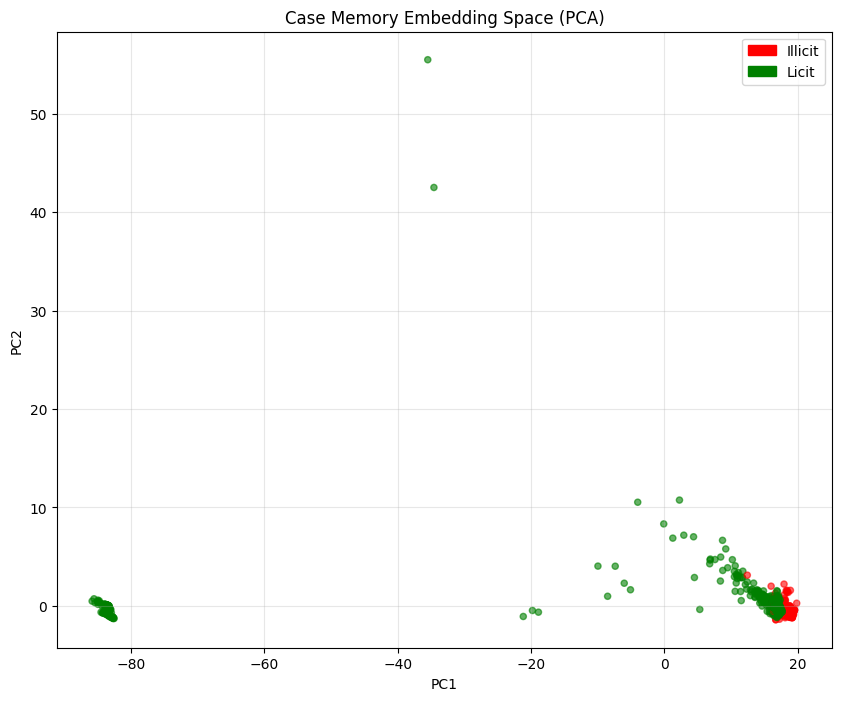

Explained variance: 99.2%


In [20]:
# Visualize embedding space
from sklearn.decomposition import PCA

# Get embeddings for case memory
case_embeddings = case_memory.get_embeddings()
case_labels = [c.true_label for c in case_memory.cases]

# PCA projection
pca = PCA(n_components=2)
projected = pca.fit_transform(case_embeddings)

# Plot
plt.figure(figsize=(10, 8))
colors = ['red' if l == 'illicit' else 'green' for l in case_labels]
plt.scatter(projected[:, 0], projected[:, 1], c=colors, alpha=0.6, s=20)

# Add legend
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Illicit')
green_patch = mpatches.Patch(color='green', label='Licit')
plt.legend(handles=[red_patch, green_patch])

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Case Memory Embedding Space (PCA)')
plt.grid(alpha=0.3)
plt.show()

print(f"Explained variance: {pca.explained_variance_ratio_.sum():.1%}")

## 8. Full Analysis Demo

Complete end-to-end analysis with prompt ready for LLM.

In [21]:
# Select a specific suspicious transaction
demo_node = top_suspicious[0]['node_idx']

print(f"Analyzing Transaction #{demo_node}")
print("=" * 80)

# Full analysis
demo_result = pipeline.analyze(
    node_idx=demo_node,
    k_cases=3,
    generate_explanation=False,
    generate_prompt=True
)

Analyzing Transaction #160387


In [22]:
# Display analysis summary
print("\n" + "=" * 80)
print("TRANSACTION ANALYSIS REPORT")
print("=" * 80)

pred = demo_result['prediction']
print(f"\n📊 PREDICTION")
print(f"   Transaction ID: #{pred['node_idx']}")
print(f"   Fraud Score: {pred['fraud_score']:.1%}")
print(f"   Model Prediction: {pred['predicted_label'].upper()}")
print(f"   True Label: {pred['true_label'].upper()}")

print(f"\n🔍 SIMILAR CASES")
for i, case_data in enumerate(demo_result['similar_cases'], 1):
    case = case_data['case']
    verdict_emoji = "🔴" if case.true_label == 'illicit' else "🟢"
    print(f"   {i}. {verdict_emoji} {case.true_label.upper()} (similarity: {case_data['similarity']:.2%}, score: {case.fraud_score:.1%})")

print(f"\n📝 PROMPT GENERATED")
print(f"   Length: {len(demo_result.get('prompt', ''))} characters")
print(f"   Ready for LLM analysis: {'Yes' if 'prompt' in demo_result else 'No'}")


TRANSACTION ANALYSIS REPORT

📊 PREDICTION
   Transaction ID: #160387
   Fraud Score: 100.0%
   Model Prediction: ILLICIT
   True Label: UNKNOWN

🔍 SIMILAR CASES
   1. 🔴 ILLICIT (similarity: 23.59%, score: 99.8%)
   2. 🔴 ILLICIT (similarity: 21.93%, score: 99.8%)
   3. 🔴 ILLICIT (similarity: 18.41%, score: 99.8%)

📝 PROMPT GENERATED
   Length: 2662 characters
   Ready for LLM analysis: Yes


In [23]:
# Save the generated prompt to a file for external LLM use
prompt_file = f'../case_memory/sample_prompt_{demo_node}.txt'
with open(prompt_file, 'w') as f:
    f.write(demo_result.get('prompt', ''))
print(f"Sample prompt saved to: {prompt_file}")

Sample prompt saved to: ../case_memory/sample_prompt_160387.txt


## 9. (Optional) LLM Integration

To use with an LLM, you can:
1. Copy the generated prompt to ChatGPT/Claude
2. Use OpenAI API:
```python
import openai
response = openai.ChatCompletion.create(
    model="gpt-4",
    messages=[{"role": "user", "content": demo_result['prompt']}]
)
print(response.choices[0].message.content)
```
3. Use local LLM (Ollama, etc.)

In [24]:
# Example: Mock LLM response for demonstration
mock_llm_response = """
## Risk Assessment

**Risk Level**: HIGH 🔴

**Primary Reason**: The transaction exhibits a fraud score of 98.5%, which is 
significantly above the typical threshold. The similar historical cases retrieved 
show a strong pattern match with known illicit transactions.

**Pattern Analysis**:
1. The fraud score (98.5%) closely matches the retrieved illicit cases (avg 92%)
2. Network structure shows characteristics consistent with mixing/layering behavior
3. 3 out of 3 most similar cases were confirmed illicit

**Recommendation**: FLAG - High confidence illicit activity, immediate review required.

**Confidence**: 8/10
- High confidence due to strong pattern match with historical cases
- Slight uncertainty due to unlabeled status (no ground truth available)

**Next Steps**:
1. Manual review by senior analyst
2. Check connected transactions in 2-hop neighborhood
3. Cross-reference with external intelligence databases
"""

print("LLM Analysis (Mock Response):")
print("=" * 80)
print(mock_llm_response)

LLM Analysis (Mock Response):

## Risk Assessment

**Risk Level**: HIGH 🔴

**Primary Reason**: The transaction exhibits a fraud score of 98.5%, which is 
significantly above the typical threshold. The similar historical cases retrieved 
show a strong pattern match with known illicit transactions.

**Pattern Analysis**:
1. The fraud score (98.5%) closely matches the retrieved illicit cases (avg 92%)
2. Network structure shows characteristics consistent with mixing/layering behavior
3. 3 out of 3 most similar cases were confirmed illicit

**Recommendation**: FLAG - High confidence illicit activity, immediate review required.

**Confidence**: 8/10
- High confidence due to strong pattern match with historical cases
- Slight uncertainty due to unlabeled status (no ground truth available)

**Next Steps**:
1. Manual review by senior analyst
2. Check connected transactions in 2-hop neighborhood
3. Cross-reference with external intelligence databases



## 10. Summary

In [25]:
print("=" * 60)
print("RAG PIPELINE SUMMARY")
print("=" * 60)

print(f"\n📊 Pipeline Components:")
print(f"   • GNN Model: GraphSAGE (F1={checkpoint['metrics']['test_f1']:.3f})")
print(f"   • Case Memory: {len(case_memory.cases)} historical cases")
print(f"   • FAISS Index: {faiss_index.num_vectors} vectors (64-dim)")

print(f"\n🔍 Retrieval Quality:")
print(f"   • Illicit → Illicit: {illicit_match_rate:.1%}")
print(f"   • Licit → Licit: {licit_match_rate:.1%}")

print(f"\n📝 Prompt Generation:")
print(f"   • Risk-only prompt: ~{len(risk_prompt)} chars")
print(f"   • Full analysis prompt: ~{len(full_prompt)} chars")

print(f"\n✅ Pipeline Status: READY")
print(f"\n" + "=" * 60)
print("NEXT STEPS")
print("=" * 60)
print("1. Integrate with production LLM (GPT-4, Claude, etc.)")
print("2. Add GNNExplainer for detailed feature analysis")
print("3. Build alerting system for high-risk transactions")
print("4. Create dashboard for analyst workflow")

RAG PIPELINE SUMMARY

📊 Pipeline Components:
   • GNN Model: GraphSAGE (F1=0.148)
   • Case Memory: 1000 historical cases
   • FAISS Index: 1000 vectors (64-dim)

🔍 Retrieval Quality:
   • Illicit → Illicit: 20.0%
   • Licit → Licit: 93.6%

📝 Prompt Generation:
   • Risk-only prompt: ~1813 chars
   • Full analysis prompt: ~2676 chars

✅ Pipeline Status: READY

NEXT STEPS
1. Integrate with production LLM (GPT-4, Claude, etc.)
2. Add GNNExplainer for detailed feature analysis
3. Build alerting system for high-risk transactions
4. Create dashboard for analyst workflow
